# ETM Project

In [24]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sc
import scipy.stats as scs
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from numba import jit, autojit
import seaborn as sns
from numba.decorators import jit,autojit
import random
import math
from datetime import timedelta
from keras import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA, ARMA
import statsmodels.api as sm
import itertools
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

In [25]:
# Data
vodafone_cell=pd.read_csv('/home/alpaslan_gokcen/Downloads/TRAFF_WEEK_LTE.CSV',error_bad_lines=False)

b'Skipping line 4021895: expected 7 fields, saw 8\nSkipping line 4021896: expected 7 fields, saw 8\nSkipping line 4021897: expected 7 fields, saw 8\nSkipping line 4021898: expected 7 fields, saw 8\n'
b'Skipping line 4522224: expected 7 fields, saw 8\nSkipping line 4522225: expected 7 fields, saw 8\nSkipping line 4522226: expected 7 fields, saw 8\nSkipping line 4522227: expected 7 fields, saw 8\n'
b'Skipping line 4941594: expected 7 fields, saw 8\nSkipping line 4941595: expected 7 fields, saw 8\nSkipping line 4941596: expected 7 fields, saw 8\nSkipping line 4941597: expected 7 fields, saw 8\n'
b'Skipping line 5981857: expected 7 fields, saw 8\nSkipping line 5981858: expected 7 fields, saw 8\nSkipping line 5981859: expected 7 fields, saw 8\nSkipping line 5981860: expected 7 fields, saw 8\nSkipping line 5981861: expected 7 fields, saw 8\nSkipping line 5981862: expected 7 fields, saw 8\nSkipping line 5981863: expected 7 fields, saw 8\nSkipping line 5981864: expected 7 fields, saw 8\n'


In [26]:
vodafone_cell.head()

,CITY_NAME,ENODEB_NAME,CELL_NAME,FRAGMENT_DATE,DATA_TRAFFIC_VOL_MB,DL_USER_TPUT_MBPS,AVG_ACT_USER_NBR
0,Kayseri,GL38_04997_Gesi,L0499715O384833471,01/08/2018,16542.07,12.94,NaN
1,Kayseri,GL38_04997_Gesi,L0499735O384833473,01/08/2018,150520.83,16.48,NaN
2,Kayseri,GL38_04997_Gesi,L0499725O384833472,01/08/2018,68819.13,17.41,NaN
3,Manisa,GL45_05473_Sart,L0547325O457252072,01/08/2018,195019.09,3.61,NaN
4,Manisa,GL45_05473_Sart,L0547315O457252071,01/08/2018,109594.67,5.36,NaN


In [27]:
vodafone_cell.describe()

,DATA_TRAFFIC_VOL_MB,DL_USER_TPUT_MBPS,AVG_ACT_USER_NBR
count,6.792036e+06,6.792036e+06,3.568689e+06
mean,1.982931e+05,1.144924e+01,1.351416e+00
std,1.872062e+05,7.893592e+00,1.659075e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.169308e+04,6.350000e+00,4.100000e-01
50%,1.467521e+05,9.430000e+00,8.900000e-01
75%,2.791643e+05,1.404000e+01,1.700000e+00
max,3.439993e+06,1.670100e+02,4.323800e+02


# Identifying the number of cells

As a first step, the number of cells, on which the project is based,are identified.

In [28]:
vodafone_cell['CELL_NAME'].nunique()#total 83526 

83526

# Sort by cell name and date

As we need cell based time dimesion, raw data, that is vodafone_cell, is corrected so as to `cell name` and `fragment date`.

In [29]:
select=vodafone_cell.sort_values(['CELL_NAME','FRAGMENT_DATE'])
# Select all rows of cell name, fragment date, and Data Traffic volume
select=vodafone_cell.loc[:,['CELL_NAME','DATA_TRAFFIC_VOL_MB','FRAGMENT_DATE']]
print(select)

                  CELL_NAME  DATA_TRAFFIC_VOL_MB FRAGMENT_DATE
0        L0499715O384833471             16542.07    01/08/2018
1        L0499735O384833473            150520.83    01/08/2018
2        L0499725O384833472             68819.13    01/08/2018
3        L0547325O457252072            195019.09    01/08/2018
4        L0547315O457252071            109594.67    01/08/2018
5        L0547335O457252073            164196.42    01/08/2018
6        L0367935O124295413            568418.15    01/08/2018
7        L0367915O124295411            537151.62    01/08/2018
8        L0367925O124295412            300049.73    01/08/2018
9        L0367935O124295433            425425.17    01/08/2018
10       L0367925O124295432            114312.13    01/08/2018
11       L0367915O124295431            216988.59    01/08/2018
12       LA427145O234306284            128773.00    01/08/2018
13       LA427135O234306283             74628.05    01/08/2018
14       LA427125O234306282            129361.29    01/

# Selection of the Active Cells

In this part, two different procedures are applied and following groups are remain intact.
* Cells having large enough time series dimension. It is assumed that data which has at least 12 data point is kept in the dataset.
* Cells which are still active as of `07/01/2019`.

In [30]:
# Active cell selection based on date
select_active=select.loc[~select['FRAGMENT_DATE'].isin(['07/01/2019'])][['CELL_NAME','DATA_TRAFFIC_VOL_MB','FRAGMENT_DATE']]
print(select_active)

                  CELL_NAME  DATA_TRAFFIC_VOL_MB FRAGMENT_DATE
0        L0499715O384833471             16542.07    01/08/2018
1        L0499735O384833473            150520.83    01/08/2018
2        L0499725O384833472             68819.13    01/08/2018
3        L0547325O457252072            195019.09    01/08/2018
4        L0547315O457252071            109594.67    01/08/2018
5        L0547335O457252073            164196.42    01/08/2018
6        L0367935O124295413            568418.15    01/08/2018
7        L0367915O124295411            537151.62    01/08/2018
8        L0367925O124295412            300049.73    01/08/2018
9        L0367935O124295433            425425.17    01/08/2018
10       L0367925O124295432            114312.13    01/08/2018
11       L0367915O124295431            216988.59    01/08/2018
12       LA427145O234306284            128773.00    01/08/2018
13       LA427135O234306283             74628.05    01/08/2018
14       LA427125O234306282            129361.29    01/

In [31]:
# Count the number of cell occurence
count_cell=select_active.groupby('CELL_NAME').count()
print(count_cell)

                    DATA_TRAFFIC_VOL_MB  FRAGMENT_DATE
CELL_NAME                                             
1800M                                52             52
2600M                                72             72
56001_0                              36             36
56007_0                              36             36
56008_0                              36             36
56023_0                              31             31
56025_0                              31             31
56029_0                              36             36
56036_0                              31             31
56038_0                              31             31
56042_0                              21             21
56045_0                               1              1
56048_0                              31             31
56049_0                              36             36
56050_0                              36             36
56052_0                              37             37
56054_0   

In [32]:
# Select cells with at least 12 data point 
select_cells = count_cell[count_cell['DATA_TRAFFIC_VOL_MB']>12] 
print(select_cells)

                    DATA_TRAFFIC_VOL_MB  FRAGMENT_DATE
CELL_NAME                                             
1800M                                52             52
2600M                                72             72
56001_0                              36             36
56007_0                              36             36
56008_0                              36             36
56023_0                              31             31
56025_0                              31             31
56029_0                              36             36
56036_0                              31             31
56038_0                              31             31
56042_0                              21             21
56048_0                              31             31
56049_0                              36             36
56050_0                              36             36
56052_0                              37             37
56054_0                              36             36
56056_0   

In [33]:
# Count unique number of indexed cells
res = select_cells.reset_index().groupby('CELL_NAME').agg(lambda x: x.nunique())
print(res.shape)

(74356, 2)


In [34]:
allData =  select_active.loc[select_active['CELL_NAME'].isin(select_cells.index)]
cells = allData['CELL_NAME'].unique()
allData.Timestamp = pd.to_datetime(allData['FRAGMENT_DATE'], format='%m/%d/%Y')
allData.index = allData.Timestamp
allData = allData.sort_index(ascending=True)
print(allData)

                        CELL_NAME  DATA_TRAFFIC_VOL_MB FRAGMENT_DATE
FRAGMENT_DATE                                                       
2017-04-03     L00C2325O346165412            120235.38    04/03/2017
2017-04-03     LE627585I555052338            204689.49    04/03/2017
2017-04-03     LK196015O207038771             67205.26    04/03/2017
2017-04-03     LK196025O207038772            112511.47    04/03/2017
2017-04-03     LK196035O207038773            161117.82    04/03/2017
2017-04-03     L0A74615O346114471             27739.37    04/03/2017
2017-04-03     L0A74625O346114472             61769.40    04/03/2017
2017-04-03     L0A74635O346114473             42892.32    04/03/2017
2017-04-03     L0A95315O346127771             32126.47    04/03/2017
2017-04-03     L0A95325O346127772             46437.86    04/03/2017
2017-04-03     L0A95335O346127773             21836.55    04/03/2017
2017-04-03     LB103015O345773171             37790.25    04/03/2017
2017-04-03     LE627565I555052336 

In [35]:
#cell_names = ['LE587935O346199833','L0471325O334082872','LB466915O334094971','LB466925O334094972','LB466935O334094973','L0020215O346012971',
 #             'L0020215O346012971','L0020225O346012972','L0020225O346012972','L0020235O346012973']


#plt.figure(figsize=(15,15))
#for i,val in enumerate(select_cells.index[:10]):
 #   data = vodafone_cell.loc[vodafone_cell['CELL_NAME'] == select_cells.index[i]]
  #  plt.plot(data['DATA_TRAFFIC_VOL_MB'], label=val)

#plt.legend(loc='best')
#plt.show()

In [36]:
p=d=q=range(0,6)

In [1]:
def arma(yt, p, q, plot_result=0):
        AIC_list_arma = pd.DataFrame({}, columns=['pram', 'AIC', 'Pred', 'y_truth', 'rmse', 'forecast'])
        # check if data is stationary or not?
        temData = adfuller(yt)
        
        #if temData[1] < 0.1:
        #    pass
        #    # stationary
        #else:
            # take difference
        #    yt = yt.diff()
        #    yt = yt.dropna()
        #    yt = yt.abs()

        y_truth = yt[split:]
        pq = list(itertools.product(p, q))
        nstep = 52
        for param in pq:
            try:
                mod = ARMA(yt, order=param)
                results = mod.fit(disp=0)
                pred_arma = results.predict(start=split, dynamic=False)
                rmse_arma = math.sqrt(((pred_arma - y_truth) ** 2).mean())
                forecast = results.forecast(steps=nstep)[0]
                temp = pd.DataFrame([[param, results.aic, np.array(pred_arma), np.array(y_truth), rmse_arma, forecast]],
                                    columns=['pram', 'AIC', 'Pred', 'y_truth', 'rmse', 'forecast'])
                AIC_list_arma = AIC_list_arma.append(temp, ignore_index=True)  # DataFrame append

                del temp
                # results.plot_predict(start=len(y_truth), end= len(yt)+10, dynamic=False)

            except:
                continue
        index = int(AIC_list_arma[['rmse']].idxmin())
        pred = AIC_list_arma.loc[[index], ['Pred']]
        y_tr = AIC_list_arma.loc[[index], ['y_truth']]
        forecast = AIC_list_arma.loc[[index], ['forecast']]
        param = AIC_list_arma.loc[[index], ['pram']]
        date_rng = pd.date_range(start=y_truth.index[-1] + timedelta(1), end=y_truth.index[-1] + timedelta(nstep * 7),
                                 freq='W')
        print(param)
        y_tr = np.array(y_tr)[0][0]
        pred = np.array(pred)[0][0]
        forecast = np.array(forecast)[0][0]
        plt.figure(figsize=(15, 5))
        if plot_result:
            plt.plot(yt.index, yt, label='yt')
            plt.plot(date_rng, forecast, label='Forecast')
            plt.plot(y_truth.index, pred, label='Prediction')
            plt.plot(y_truth.index, y_tr, label='Actual')
            plt.legend()
            plt.show()
        #print("ARMA->", AIC_list_arma.loc[[index], ['rmse']])
        """
                        First param. returns RMSE,
                        Second param Return Forecast Values
                """
        return AIC_list_arma.loc[[index], ['rmse']].values[0][0], forecast, date_rng

In [2]:
i = 0
test_results = [] #index 0: rmse, index 1:forecast, index 2: date

for cell in cells:
#   print("Cell NAME:->", cell)
    cellData = allData.loc[allData['CELL_NAME']== 'L0367925O124295432'] #'L0367925O124295432']
    cellData = cellData['DATA_TRAFFIC_VOL_MB']
    #split_date = pd.Timestamp('2018-12-24')
    #train = veri.loc[:split_date]
    #test = veri.loc[split_date:]
    split = int(cellData.shape[0]*0.7)
    yt_train = cellData[:split]
    yt_test = cellData[split:]
    yt = cellData.sort_index(ascending=True)
    yt = yt / 1024
    #AIC_list_arma.loc[[index], ['rmse']].values[0][0], forecast, date_rng=arma(yt, p, q)
    rmse, forecast, date = arma(yt, p, q, plot_result=1)
    test_results.append([rmse, forecast, date])
    #print("Cell->",cell, " RMSE: ", rmse," Forecast:", forecast, date)  
    i = i+1
    if i>0:
        for item in test_results:
            print(item[1])
        test_results = pd.DataFrame.from_dict(test_results)
        test_results.to_excel('testResult.xlsx')
        break

NameError: name 'cells' is not defined

# SARIMA

In [54]:
p = d=q = range(0,2)

In [65]:
def sarima(yt, p, d, q, plot_result=0):
    """ Seasonally Autoregressive Integrated Moving Average """
    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    # STEP
    nstep = 12
    y_truth = yt[split:]
    AIC_list_sarima = pd.DataFrame({}, columns=['pram', 'AIC', 'Pred', 'y_truth', 'rmse', 'forecast'])
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(yt,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit(disp=0)

            pred = results.get_prediction(start=split, dynamic=False)
            prediction = pred.predicted_mean
            fore = results.get_forecast(steps=nstep)
            forecast = fore.predicted_mean
            rmse_sarima = math.sqrt(((prediction - y_truth) ** 2).mean())

            temp = pd.DataFrame(
                [[param, results.aic, np.array(prediction), np.array(y_truth), rmse_sarima, forecast]],
                columns=['pram', 'AIC', 'Pred', 'y_truth', 'rmse', 'forecast'])
            AIC_list_sarima = AIC_list_sarima.append(temp, ignore_index=True)  # DataFrame append

    index = int(AIC_list_sarima[['rmse']].idxmin())
    pred = AIC_list_sarima.loc[[index], ['Pred']]
    y_tr = AIC_list_sarima.loc[[index], ['y_truth']]
    forecast = AIC_list_sarima.loc[[index], ['forecast']]
    #date_rng = pd.date_range(start=y_truth.index[-1], end=y_truth.index[-1] + timedelta(nstep * 7),
    #                         freq='W')
    #date_rng = pd.date_range(periods=7, start=y_truth.index[-1], freq='M')[1:]
    date_rng = pd.date_range(start=y_truth.index[-1] + timedelta(1), end=y_truth.index[-1] + timedelta(nstep * 7),
                                 freq='W')
    y_tr = np.array(y_tr)[0][0]
    pred = np.array(pred)[0][0]
    forecast = np.array(forecast)[0][0]
    if plot_result:
        plt.figure(figsize=(12, 5))
        plt.plot(yt.index, yt, label='Train')
        plt.plot(date_rng, forecast, label='Forecast')
        #plt.plot(y_truth.index, pred, label='Prediction')
        plt.plot(y_truth.index, y_tr, label='Actual')
        plt.legend()
        plt.show()

    #print("SARIMA->", AIC_list_sarima.loc[[index], ['rmse']])
    """
            First param. returns RMSE,
            Second param Return Forecast Values
    """
    return AIC_list_sarima.loc[[index],['rmse']], forecast, date_rng

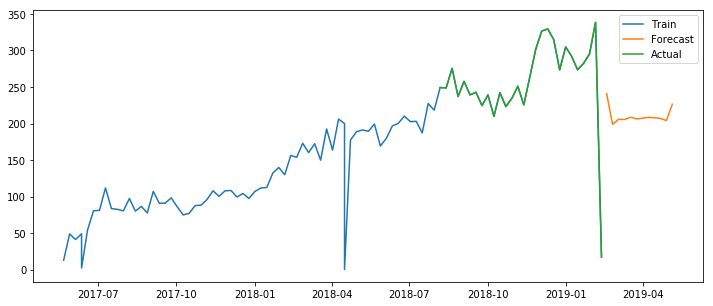

93     240.819927
94     198.773427
95     205.746803
96     205.422035
97     208.576707
98     206.268440
99     207.258301
100    208.475940
101    207.907106
102    207.046892
103    203.979717
104    226.378814
dtype: float64


In [66]:
i = 0
test_results = [] #index 0: rmse, index 1:forecast, index 2: date

for cell in cells:
#   print("Cell NAME:->", cell)
    cellData = allData.loc[allData['CELL_NAME']== 'L0367925O124295432'] #'L0367925O124295432']
    cellData = cellData['DATA_TRAFFIC_VOL_MB']
    #split_date = pd.Timestamp('2018-12-24')
    #train = veri.loc[:split_date]
    #test = veri.loc[split_date:]
    split = int(cellData.shape[0]*0.7)
    yt_train = cellData[:split]
    yt_test = cellData[split:]
    yt = cellData.sort_index(ascending=True)
    yt = yt / 1024
    #AIC_list_arma.loc[[index], ['rmse']].values[0][0], forecast, date_rng=arma(yt, p, q)
    rmse, forecast, date = sarima(yt, p, q, d,1)
    test_results.append([rmse, forecast, date])
    #print("Cell->",cell, " RMSE: ", rmse," Forecast:", forecast, date)  
    i = i+1
    if i>0:
        for item in test_results:
            print(item[1])
        test_results = pd.DataFrame.from_dict(test_results)
        test_results.to_excel('SarimaTestResult.xlsx')
        break

# LSTM

In [150]:
def LSTM_custom( yt, hidden_neurons, dropout_parameter, epoch, batch_size, plot_result=0):

    testDate = pd.DataFrame(yt[split:])

    #yt = np.reshape(yt, (-1, 1))

    train = yt[0:split]
    test = yt[split:]

    def create_dataset(yt, look_back=1):
        X, Y = [], []
        for i in range(len(yt) - look_back - 1):
            a = yt[i:(i + look_back), 0]
            X.append(a)
            Y.append(yt[i + look_back, 0])
        return np.array(X), np.array(Y)

    look_back = 1
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    model = Sequential()
    #model.add(LSTM(100, activation='relu', input_shape=(X_train[1], 1), return_sequences=True))
    model.add(LSTM(hidden_neurons, input_shape=(X_train.shape[1], 1), activation='relu', return_sequences=True))

    model.add(Dropout(dropout_parameter))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, Y_train, epochs=100, batch_size=20, validation_data=(X_test, Y_test), verbose=0,
                        shuffle=False)
    #model.summary()

    pred = model.predict(X_test)
    forecastStart = X_test[1]
    x_input = forecastStart
    x_input.reshape((1,X_train.shape[1] , 1))
    
    tempList = list()

    for item in range(52):
        x_input = x_input.reshape((1, X_train.shape[1], 1))
        yhat = model.predict(x_input, verbose=0)
        x_input = np.append(x_input, yhat)
        x_input = x_input[1:]
        #x_input = x_input.reshape((1, n_steps, n_features))
        tempList.append(yhat)
    
    
    X_test = np.array(X_test).flatten()
    
    if plot_result:
        plt.plot(train.index, train['y'], label='train')
        plt.plot(test.index, test['y'], label=' Original')
        plt.plot(test.index, np.array(tempList).flatten(), label='Forecast')
        plt.legend()
        plt.show()
    """
    if plot_result:
        plt.plot(testDate[:-2].index, X_test)
        plt.plot(testDate[:-2].index, pred)
        print(math.sqrt(mean_squared_error(pred, X_test)))
        plt.show()
    """
    #First param. returns RMSE,
    #Second param Return Forecast Values
    # TODO forecast should be return from here instead of prediction
    return math.sqrt(mean_squared_error(pred, X_test)), pred,tempList

In [154]:
i = 0
test_results = [] #index 0: rmse, index 1:forecast, index 2: date

for cell in cells:
#   print("Cell NAME:->", cell)
    cellData = allData.loc[allData['CELL_NAME']== 'L0367925O124295432'] #'L0367925O124295432']
    cellData = cellData['DATA_TRAFFIC_VOL_MB']
    #split_date = pd.Timestamp('2018-12-24')
    #train = veri.loc[:split_date]
    #test = veri.loc[split_date:]
    split = int(cellData.shape[0]*0.7)
    yt_train = cellData[:split]
    yt_test = cellData[split:]
    yt = cellData.sort_index(ascending=True)
    yt = yt / 1024
    yt = np.array(yt)
    yt = np.reshape(yt, (-1,1))
    #AIC_list_arma.loc[[index], ['rmse']].values[0][0], forecast, date_rng=arma(yt, p, q)
    rmse, pred,forecast = LSTM_custom(yt, 64, 0.2, 100, 20, plot_result=0)
    test_results.append([rmse, pred,forecast])
    #print("Cell->",cell, " RMSE: ", rmse," Forecast:", forecast, date)  
    i = i+1
    if i>1:
        for item in test_results:
            print(item[1])
            test_results = pd.DataFrame.from_dict(test_results)
            test_results.to_excel('testResult.xlsx')
        break

[[239.32645]
 [238.84264]
 [263.97263]
 [227.75995]
 [247.2761 ]
 [229.88065]
 [233.25897]
 [216.09183]
 [229.81436]
 [202.27274]
 [232.81187]
 [214.67633]
 [225.46976]
 [240.95937]
 [216.98624]
 [252.74303]
 [288.43225]
 [311.39453]
 [314.11276]
 [300.68597]
 [261.92377]
 [291.2855 ]
 [279.32004]
 [262.16   ]
 [270.23035]
 [282.45645]]
[[247.72766]
 [247.21475]
 [273.9301 ]
 [235.48097]
 [256.1632 ]
 [237.72403]
 [241.29945]
 [223.15837]
 [237.65392]
 [208.60454]
 [240.8261 ]
 [221.66562]
 [233.05983]
 [249.45915]
 [224.10182]
 [261.9731 ]
 [300.0828 ]
 [324.77414]
 [327.7062 ]
 [313.2421 ]
 [271.74625]
 [303.14343]
 [290.3222 ]
 [271.998  ]
 [280.6067 ]
 [293.6794 ]]


In [159]:
X_input.flatten()

NameError: name 'X_input' is not defined

In [158]:
test_results

,0,1,2
0,11.129869,"[[239.32645], [238.84264], [263.97263], [227.7...","[[[238.84264]], [[229.5613]], [[220.83551]], [..."
1,1.571339,"[[247.72766], [247.21475], [273.9301], [235.48...","[[[247.21474]], [[245.70827]], [[244.21056]], ..."


In [163]:
testDate = pd.DataFrame(yt[split:])

#yt = np.reshape(yt, (-1, 1))

train = yt[0:split]
test = yt[split:]

def create_dataset(yt, look_back=1):
    X, Y = [], []
    for i in range(len(yt) - look_back - 1):
        a = yt[i:(i + look_back), 0]
        X.append(a)
        Y.append(yt[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
#model.add(LSTM(100, activation='relu', input_shape=(X_train[1], 1), return_sequences=True))
model.add(LSTM(64, input_shape=(X_train.shape[1], 1), activation='relu', return_sequences=True))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=100, batch_size=20, validation_data=(X_test, Y_test), verbose=0,
                    shuffle=False)
#model.summary()

pred = model.predict(X_test)
forecastStart = X_test[1]
x_input = forecastStart
x_input.reshape((1,X_train.shape[1] , 1))

tempList = list()
Xlist = list()
for item in range(52):
    Xlist.append(x_input.flatten())
    x_input = x_input.reshape((1, X_train.shape[1], 1))
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    #x_input = x_input.reshape((1, n_steps, n_features))
    tempList.append(yhat)


X_test = np.array(X_test).flatten()
for item in X_test:
    print(item)

249.245712890625
248.7298828125
275.578603515625
236.92548828125
257.7273828125
239.182587890625
242.77986328125
224.521318359375
239.11203125
209.861884765625
242.303662109375
223.01818359375
234.48890625
250.9869921875
225.4712890625
263.566826171875
301.821884765625
326.559306640625
329.494150390625
315.010703125
273.385341796875
304.890380859375
292.03234375
273.63818359375
282.2822265625
295.40017578125


# Pyramid

In [1]:
i = 0
test_results = [] #index 0: rmse, index 1:forecast, index 2: date
from pmdarima.arima import auto_arima

for cell in cells:

    cellData = allData.loc[allData['CELL_NAME']== 'L0367925O124295432'] #'L0367925O124295432']
    cellData = cellData['DATA_TRAFFIC_VOL_MB']
    
    yt = cellData.sort_index(ascending=True)
    yt = yt / 1024

    
    model = auto_arima(yt,start_p=1,start_q=1,max_q=8,max_p=8,
                       start_P=,start_Q=
                       #w=1,
                       #seasonal=True,
                       #trace=True,
                       #error_action='ignore',
                       #suppress_warnings=True,
                       #stepwise=True,
                       #maxiter=100
                      )
    
    model.fit(yt)
    
    f = model.predict(n_periods=52)

    date_rng = pd.date_range(start=yt.index[-1] + timedelta(1), end=yt.index[-1] + timedelta(52 * 7),
                                 freq='W')
    plt.plot(yt.index,yt, label='Train')
    plt.plot(date_rng, f , label='Forecast')
    plt.legend()
    plt.show()
    i = i + 1
    if i>5:
        break

SyntaxError: invalid syntax (<ipython-input-1-d93313d6357c>, line 15)

In [ ]:
#building the model


In [175]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [176]:
n_features = 1

In [189]:
d = yt

#train_data = d[:int(d.shape[0] * 0.8)]
train_data = d

n_steps = train_data.shape[0]//3

test_data = d[int(d.shape[0] * 0.8):]

In [190]:
from keras.layers import Dropout
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
#model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
#model.add(LSTM(32,activation='relu'))  # returns a sequence of vectors of dimension 32
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [196]:
import numpy as np
X, y = split_sequence(train_data, n_steps)
X = X.reshape((X.shape[0], X.shape[1], n_features))
model.fit(X, y, epochs=200,batch_size=20, verbose=1)
forecastStart = X[X.shape[0] - 1]  # get final values of time series to start forecast

Epoch 1/200
62/62 [==============================] - 0s 1ms/step - loss: 3340.0851
Epoch 2/200
62/62 [==============================] - 0s 941us/step - loss: 2456.2265
Epoch 3/200
62/62 [==============================] - 0s 1ms/step - loss: 3785.8539
Epoch 4/200
62/62 [==============================] - 0s 953us/step - loss: 2978.8517
Epoch 5/200
62/62 [==============================] - 0s 1ms/step - loss: 3149.7608
Epoch 6/200
62/62 [==============================] - 0s 993us/step - loss: 3808.7814
Epoch 7/200
62/62 [==============================] - 0s 1ms/step - loss: 3611.5607
Epoch 8/200
62/62 [==============================] - 0s 1ms/step - loss: 2803.0499
Epoch 9/200
62/62 [==============================] - 0s 990us/step - loss: 2562.3175
Epoch 10/200
62/62 [==============================] - 0s 1ms/step - loss: 2377.4905
Epoch 11/200
62/62 [==============================] - 0s 852us/step - loss: 3246.3602
Epoch 12/200
62/62 [==============================] - 0s 1ms/step - loss: 2

In [197]:
x_input = forecastStart
x_input.reshape((1, n_steps, n_features))

array([[[202.94921875],
        [187.04759766],
        [227.33625   ],
        [218.33541016],
        [249.24571289],
        [248.72988281],
        [275.57860352],
        [236.92548828],
        [257.72738281],
        [239.18258789],
        [242.77986328],
        [224.52131836],
        [239.11203125],
        [209.86188477],
        [242.30366211],
        [223.01818359],
        [234.48890625],
        [250.98699219],
        [225.47128906],
        [263.56682617],
        [301.82188477],
        [326.55930664],
        [329.49415039],
        [315.01070313],
        [273.3853418 ],
        [304.89038086],
        [292.03234375],
        [273.63818359],
        [282.28222656],
        [295.40017578],
        [338.50094727]]])

In [198]:
tempList = list()

for item in range(52):
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    #x_input = x_input.reshape((1, n_steps, n_features))
    tempList.append(yhat)

In [199]:
date_rng = pd.date_range(start=train_data.index[-1] + timedelta(1), end=train_data.index[-1] + timedelta(52 * 7),
                                 freq='W')

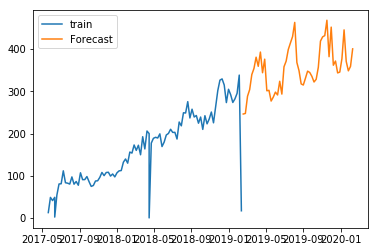

In [200]:
plt.plot(train_data.index, train_data, label='train')
plt.plot(date_rng, np.array(tempList).flatten(), label='Forecast')
plt.legend()
plt.show()